In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from math import sqrt
from skimage import data
from skimage.feature import blob_doh
from skimage.color import rgb2gray
from sklearn.cluster import KMeans

In [2]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)


def show_points_on_image(raw_image, input_points, input_labels=None):
    plt.figure(figsize=(10,10))
    plt.imshow(raw_image)
    input_points = np.array(input_points)
    if input_labels is None:
      labels = np.ones_like(input_points[:, 0])
    else:
      labels = np.array(input_labels)
    show_points(input_points, labels, plt.gca())
    plt.axis('on')
    plt.show()

### retrieving masks from numpy cache

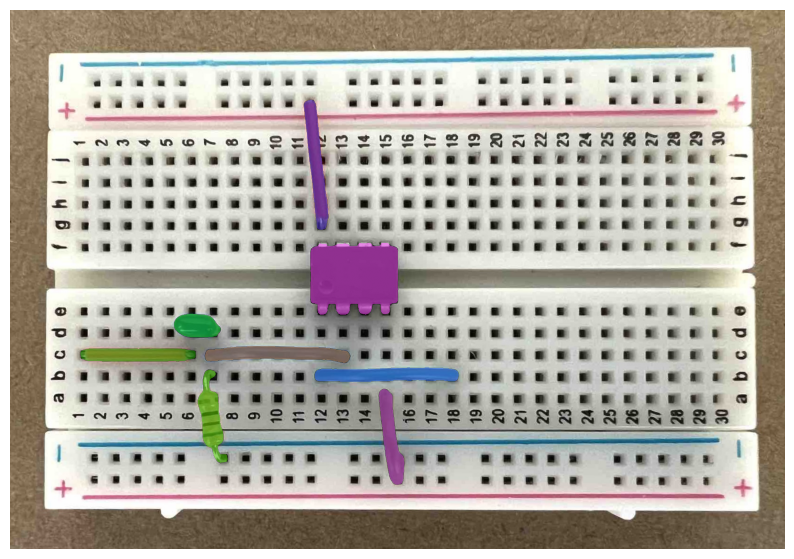

In [3]:
image = cv2.imread('../images/simple.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# read sorted_masks.npy
sorted_masks = np.load('sorted_masks.npy')

plt.figure(figsize=(10, 10))
plt.imshow(image)
for mask in sorted_masks:
    show_mask(mask, plt.gca(), random_color=True)
plt.axis('off')
plt.show()

area:  25385


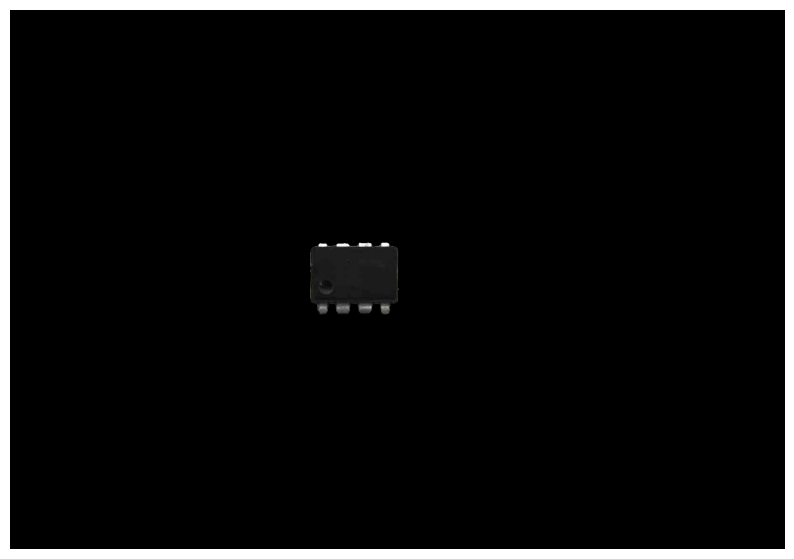

In [4]:
# sort sorted_masks by area, in descending order
sorted_masks = sorted(sorted_masks, key=lambda x: np.sum(x))
sorted_masks = sorted_masks[::-1]

selected_mask = sorted_masks[0]
print("area: ", np.sum(selected_mask))

# Apply the mask to the image
selected_mask = np.array(selected_mask[0], dtype=np.uint8)
masked_image = cv2.bitwise_and(image, image, mask=selected_mask)

# display the result
plt.figure(figsize=(10, 10))
plt.imshow(masked_image)
plt.axis('off')
plt.show()

In [44]:
# classes for CLIP:
# everything that has >95% accuracy is legit
# chips and resistors are identified with lije 99% accuracy based on these classes:
# 1. beige non-uniform cylindrical object with colored stripes and two metallic leads coming out from the sides; 
# 2. black rectangular object with two rows of pins located on the sides in parallel fashion; 
# 3. wire

# pictures of wires are not identified very good
# accuracy for resistors and chips is much better when the image you're passing is cropped to the object

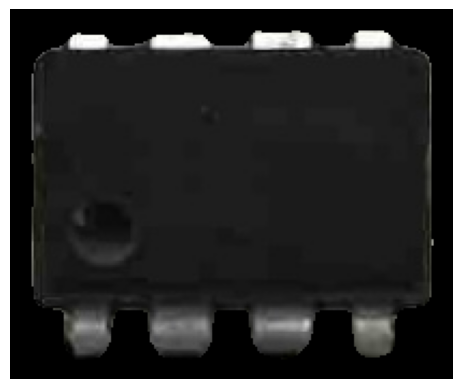

In [5]:
# crop the masked_image to the object, leaving some margin
# this is the image that will be passed to CLIP

# iterate through the selected_mask and find the min and max x and y coordinates
# these will be the coordinates of the bounding box
min_x = 100000
min_y = 100000

max_x = 0
max_y = 0

for i in range(len(selected_mask)):
    for j in range(len(selected_mask[0])):
        if selected_mask[i][j] == 1:
            if i < min_y:
                min_y = i
            if j < min_x:
                min_x = j
            if i > max_y:
                max_y = i
            if j > max_x:
                max_x = j

# crop the image
margin = 10
cropped_image = masked_image[min_y-margin:max_y+margin, min_x-margin:max_x+margin]

# display the result
plt.imshow(cropped_image)
plt.axis('off')
plt.show()

### loading models

In [8]:
from PIL import Image
import requests

from transformers import CLIPProcessor, CLIPModel

model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [10]:
def classify_mask(selected_mask):
    resistor_descr = "beige non-uniform cylindrical object with colored stripes and two metallic leads coming out from the sides"
    chip_descr = "black rectangular object with two rows of pins located on the sides in parallel fashion"
    wire_descr = "wire"

    # Apply the mask to the image
    selected_mask = np.array(selected_mask[0], dtype=np.uint8)
    masked_image = cv2.bitwise_and(image, image, mask=selected_mask)

    # crop the masked_image to the object, leaving some margin
    # this is the image that will be passed to CLIP

    # iterate through the selected_mask and find the min and max x and y coordinates
    # these will be the coordinates of the bounding box
    min_x = 100000
    min_y = 100000

    max_x = 0
    max_y = 0

    for i in range(len(selected_mask)):
        for j in range(len(selected_mask[0])):
            if selected_mask[i][j] == 1:
                if i < min_y:
                    min_y = i
                if j < min_x:
                    min_x = j
                if i > max_y:
                    max_y = i
                if j > max_x:
                    max_x = j

    # crop the image
    margin = 10
    cropped_image = masked_image[min_y-margin:max_y+margin, min_x-margin:max_x+margin]

    inputs = processor(text=[resistor_descr, chip_descr, wire_descr], images=cropped_image, return_tensors="pt", padding=True)

    outputs = model(**inputs)
    logits_per_image = outputs.logits_per_image  # this is the image-text similarity score
    probs = logits_per_image.softmax(dim=1)  # we can take the softmax to get the label probabilities

    # convert the probabilities to percentages
    probs = probs * 100
    probs = probs.detach().numpy()

    # print the probabilities
    print("resistor: ", probs[0][0])
    print("chip: ", probs[0][1])
    print("wire: ", probs[0][2])

    # if any of the probabilities is >98%, return the corresponding class
    # otherwire, return wire
    prob_threshold = 98
    if probs[0][0] > prob_threshold:
        return "resistor"
    elif probs[0][1] > prob_threshold:
        return "chip"
    else:
        return "wire"


In [13]:
prediction = classify_mask(selected_mask=sorted_masks[0])
print("\nprediction:", prediction)

resistor:  0.13385609
chip:  99.839264
wire:  0.026877122

prediction: chip


In [56]:
input_boxes = [[90, 97, 1590, 1065]]
def identify_raw_keypoints(img):

    # identify blobs in the image and constrain them to the input boxes
    detector = cv2.SimpleBlobDetector_create()
    keypoints = detector.detect(img)

    # delete keypoints if they are not in the input boxes
    keypoints = [kp for kp in keypoints if kp.pt[0] > input_boxes[0][0] and kp.pt[0] < input_boxes[0][2] and kp.pt[1] > input_boxes[0][1] and kp.pt[1] < input_boxes[0][3]]

    # sort keypoints by y coordinate
    keypoints.sort(key=lambda x: x.pt[1])
    keypoints = [kp.pt for kp in keypoints]
    keypoints = np.array(keypoints, dtype=np.int32)

    # print the total number of keypoints
    print("Total number of keypoints: {}".format(len(keypoints)))

    return keypoints

Total number of keypoints: 373


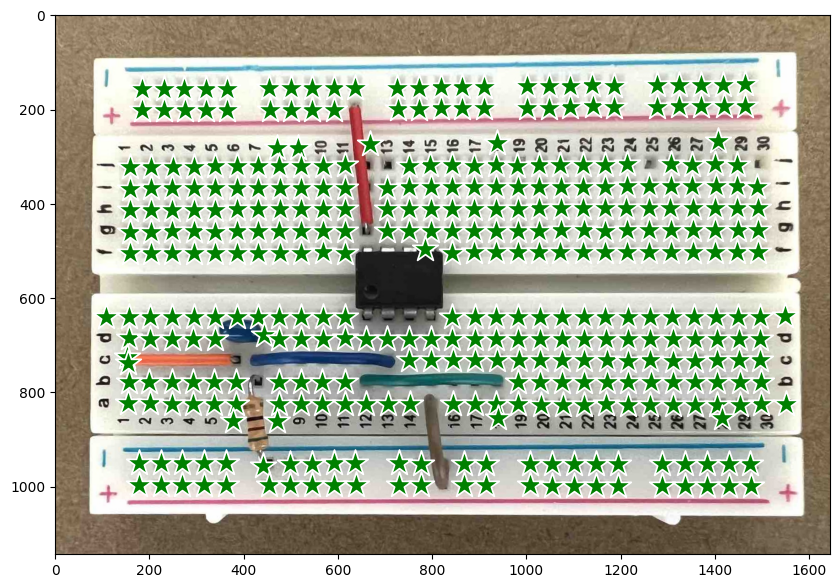

In [57]:
raw_keypoints = identify_raw_keypoints(image)
show_points_on_image(image, raw_keypoints)